In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738535 entries, 0 to 1515864
Data columns (total 3 columns):
LCLid             object
tstp              datetime64[ns]
energy(kWh/hh)    float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 83.6+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39340


39225

In [8]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0

In [9]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,month,day,week,hour
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.393734,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.529373,0.050786,0.495566,0.479369
std,0.177905,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.306145,0.028288,0.307568,0.288379
min,0.025000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.083333,0.003226,0.019231,0.000000
25%,0.266000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.250000,0.025806,0.211538,0.250000
50%,0.378571,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.500000,0.051613,0.480769,0.500000
75%,0.501250,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.833333,0.074194,0.769231,0.750000
max,1.914000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,0.100000,1.000000,0.958333


In [10]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

# Plot helpers

In [11]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6)
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.5,
          facecolor='#65c9f7',
          interpolate=True)

    # Make the plot pretty
#     plt.ylim([context_y.min()-1, context_y.max()+1])
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid('off')
    ax = plt.gca()
    plt.show()

In [12]:
def plot_from_loader(loader, undo_log=use_logy, title=''):
    data = next(iter(loader))
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        plt.title(title+f" loss={loss: 2.2g}")
        plot_functions(target_x.detach().cpu().numpy(),
                        target_y.detach().cpu().numpy(),
                        context_x.detach().cpu().numpy(),
                        context_y.detach().cpu().numpy(),
                        y_pred.detach().cpu().numpy(),
                        y_std.detach().cpu().numpy(), undo_log=undo_log)
    return loss_test

# Dataloaders

In [14]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [19]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [20]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 101, 13]), torch.Size([32, 101, 1]))

In [21]:
from src.models.model import LatentModel
model = LatentModel(
    x_dim=x.shape[-1], 
    y_dim=y.shape[-1], 
    hidden_dim=64, 
    latent_dim=64,
    dropout=0.5,
    num_heads=8,
    n_latent_encoder_layers=4,
    n_det_encoder_layers=4,
    n_decoder_layers=4,
    latent_enc_self_attn_type="multihead", 
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead").to(device)

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

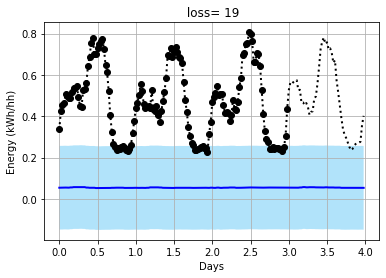

0, i=0, loss: 19.05, test: 3.835, grad_norm:  4e+02, std:  0.24


In [ ]:
epochs = 100
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%300==0:
            model.eval()
            test_loss = plot_from_loader(loader_test)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item()}, grad_norm: {grad_norm: 2.2g}")

In [ ]:
plot_from_loader(loader_test)

In [ ]:
plot_from_loader(loader_train, undo_log=False)

In [ ]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['n']/(df_hist['epoch']+1)
df_hist = df_hist.set_index('n')
df_hist

In [ ]:
df_hist[['loss', 'test_loss']].plot()